In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy import integrate, interpolate, stats, special
from tqdm import tqdm
import pickle
import os
from sigfig import round

import git
from pathlib import Path
import os
import cv2
import numpy as np
from glob import glob

# Import MATLAB Engine API for Python
ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.getcwd()
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import *
from reporting import *
os.chdir(CWD)
plots_path = os.path.join(ROOT_DIR, "publication", "paper", "final_plots")
fontsize = 20
SAVE_FIGS = True

/var/folders/0c/5hhs4r6n7pnc4jcl295d7j_c0000gn/T/ipykernel_32896/2987776652.py:134: UserWarning: 2 significant figures requested from number with only 1 significant figures
  r_contour = [round(i*0.01 + 0.5, sigfigs=2) for i in range(-10, 360)]
/var/folders/0c/5hhs4r6n7pnc4jcl295d7j_c0000gn/T/ipykernel_32896/2987776652.py:135: UserWarning: 2 significant figures requested from number with only 1 significant figures
  eta_contour = [round(j*0.02 + 1, sigfigs=2) for j in range(-50, 400)]
/var/folders/0c/5hhs4r6n7pnc4jcl295d7j_c0000gn/T/ipykernel_32896/2987776652.py:265: UserWarning: 2 significant figures requested from number with only 1 significant figures
  r_contour = [round(i*0.01 + 0.5, sigfigs=2) for i in range(-10, 360)]


Processing r0=0.5, eta0=0
Loading existing gradient data from ks_gradient_data/gradient_data_r50_eta0_eps10_theta100.pkl
KS Derivatives range: 0.022075759099210442, 0.7914887269477865
Processing r0=0.5, eta0=0.5
Loading existing gradient data from ks_gradient_data/gradient_data_r50_eta50_eps10_theta100.pkl
KS Derivatives range: 0.013870231829749, 0.9391626459687162
Processing r0=0.5, eta0=1
Loading existing gradient data from ks_gradient_data/gradient_data_r50_eta100_eps10_theta100.pkl
KS Derivatives range: 0.010009018214240939, 1.0604514940504295
Processing r0=0.5, eta0=1.5
Loading existing gradient data from ks_gradient_data/gradient_data_r50_eta150_eps10_theta100.pkl
KS Derivatives range: 0.020745471407401794, 1.162211134958513
Processing r0=0.5, eta0=2
Loading existing gradient data from ks_gradient_data/gradient_data_r50_eta200_eps10_theta100.pkl
KS Derivatives range: 0.00741100764645175, 1.249205444120438
Processing r0=0.5, eta0=2.5
Loading existing gradient data from ks_gradient

/var/folders/0c/5hhs4r6n7pnc4jcl295d7j_c0000gn/T/ipykernel_32896/2987776652.py:266: UserWarning: 2 significant figures requested from number with only 1 significant figures
  eta_contour = [round(j*0.02 + 1, sigfigs=2) for j in range(-50, 400)]
/var/folders/0c/5hhs4r6n7pnc4jcl295d7j_c0000gn/T/ipykernel_32896/2987776652.py:335: RuntimeWarning: divide by zero encountered in scalar divide
  width, height = scale_factor / np.sqrt(s[0]), scale_factor / np.sqrt(s[1])  # Axis lengths
/var/folders/0c/5hhs4r6n7pnc4jcl295d7j_c0000gn/T/ipykernel_32896/2987776652.py:352: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


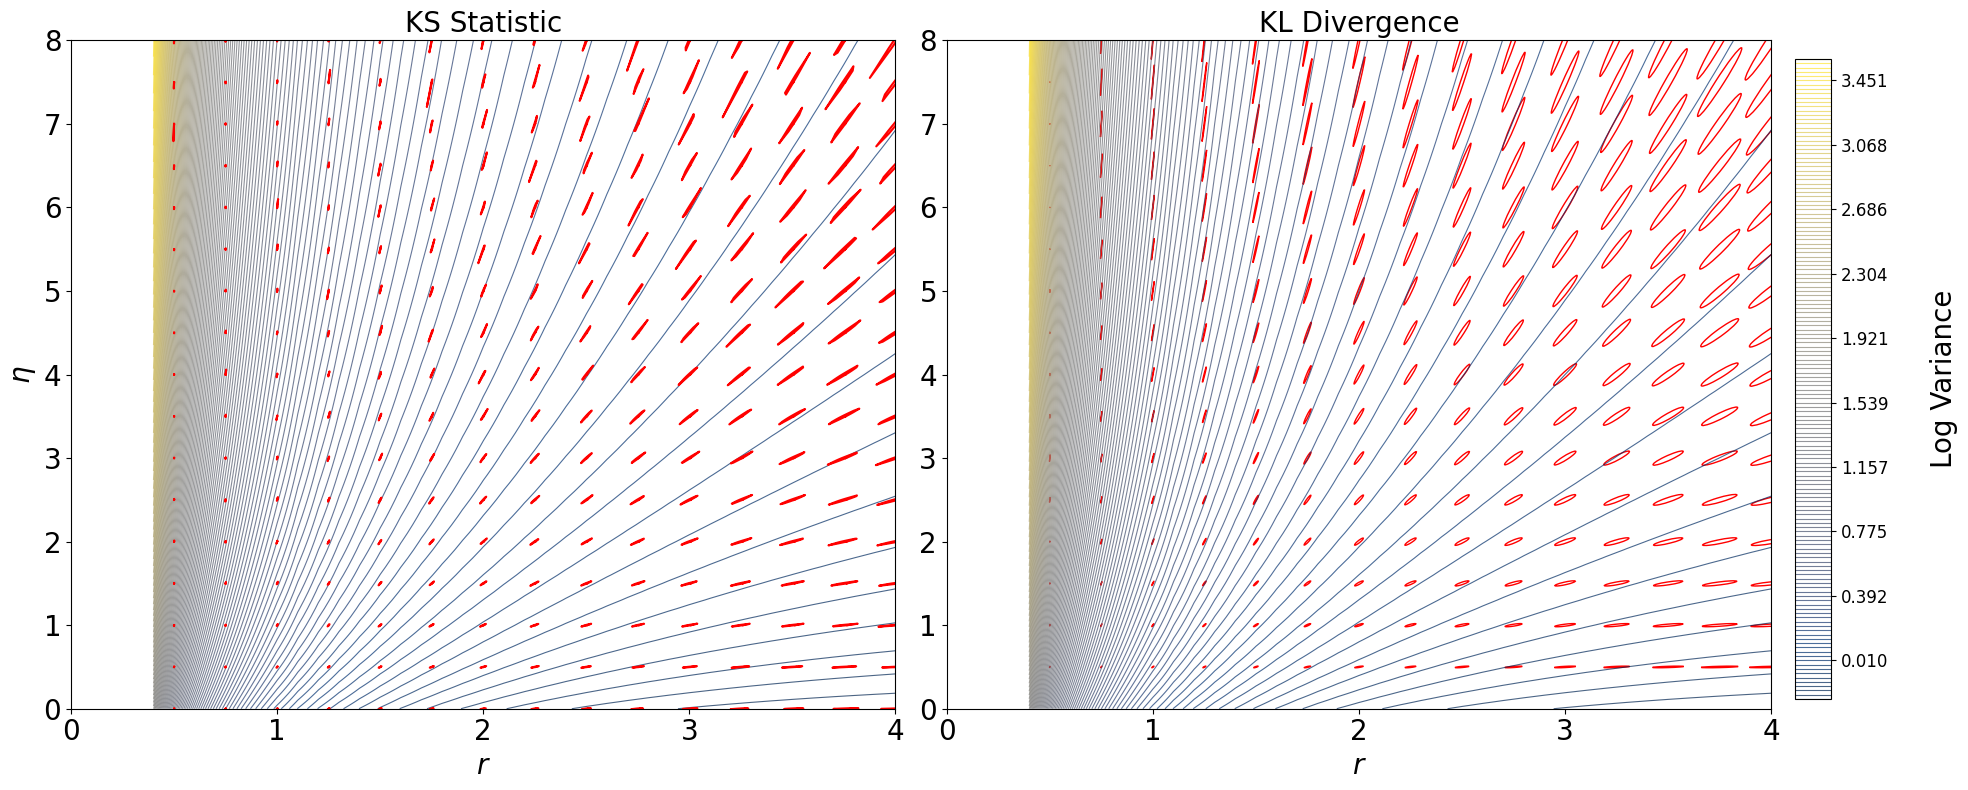

/Users/brandonmarks/opt/anaconda3/envs/HBMV/lib/python3.10/site-packages/matplotlib/transforms.py:2070: RuntimeWarning: invalid value encountered in scalar multiply
  self._mtx[1, 0] *= sy
/Users/brandonmarks/opt/anaconda3/envs/HBMV/lib/python3.10/site-packages/matplotlib/transforms.py:2072: RuntimeWarning: invalid value encountered in scalar multiply
  self._mtx[1, 2] *= sy
/Users/brandonmarks/opt/anaconda3/envs/HBMV/lib/python3.10/site-packages/matplotlib/transforms.py:2070: RuntimeWarning: invalid value encountered in scalar multiply
  self._mtx[1, 0] *= sy
/Users/brandonmarks/opt/anaconda3/envs/HBMV/lib/python3.10/site-packages/matplotlib/transforms.py:2072: RuntimeWarning: invalid value encountered in scalar multiply
  self._mtx[1, 2] *= sy


In [17]:
fig, (ax_ks, ax_kl) = plt.subplots(1, 2, figsize=(18, 8))

# Utility Functions (Updated)

def compute_cdf_vals(r, beta, xs, use_matlab=False, debug=False):
    prior_cdf = np.zeros_like(xs)
    if use_matlab:
        if debug:
            for j in tqdm(range(len(xs)), desc="Computing CDF with MATLAB"):
                prior_cdf[j] = eng.compute_cdf_using_gengamma(float(r), float(beta), float(xs[j]), nargout=1)
        else:
            for j, x in enumerate(xs):
                prior_cdf[j] = eng.compute_cdf_using_gengamma(float(r), float(beta), float(x), nargout=1)
    else:
        def gen_gamma_density(theta):
            return (np.abs(r) / special.gamma(beta)) * (theta) ** (r * beta - 1) * np.exp(-(theta) ** r)

        for idx, x in enumerate(xs):
            def integrand(theta):
                cdf_normal = stats.norm.cdf(x / np.sqrt(theta))
                return cdf_normal * gen_gamma_density(theta)
            # Integrate over theta from 0 to infinity
            result, _ = integrate.quad(integrand, 0, np.inf, limit=100)
            prior_cdf[idx] = result
            if debug and idx % 100 == 0:
                print(f"x={x:.2f}, CDF={prior_cdf[idx]:.5f}")
    return prior_cdf

def sample_prior(r, eta, size=1):
    beta = (eta + 1.5)/r 
    assert beta > 0
    vars = stats.gengamma.rvs(a=beta, c=r, size=size)
    x = np.random.normal(scale=np.sqrt(vars), size=size)
    return x

def compute_prior_cdf_using_gamma_cdf(r, eta, n_samples=1000, tail_bound=0.001, tail_percent=0.1, scale=1, use_matlab=True, eng=None, enforce_assert=True, return_assert=False, return_xs=False, debug=False):
    beta = (eta + 1.5) / r
    var_prior = scale * special.gamma(beta + 1/r) / special.gamma(beta)
    
    cheby = np.sqrt(var_prior / tail_bound)
    if np.isnan(var_prior) or np.isinf(var_prior):
        cheby = 1e100
    x_max = min(99, cheby)
    n_tail = int(n_samples * tail_percent) if cheby >= 120 else 0

    if debug:
        print(f"Params: r={r}, eta={eta}")
        print(f"Chebyshev bound: {cheby}")
        print(f"{'No tail' if n_tail == 0 else f'Tail samples: {n_tail}'}")

    xs_minus = np.concatenate((-np.logspace(np.log10(cheby), 2, n_tail),
                               np.linspace(-x_max, 0, n_samples//2-n_tail)))

    prior_cdf_minus = compute_cdf_vals(r, beta, xs_minus, use_matlab=use_matlab, debug=debug)

    xs_plus = -np.flip(xs_minus[:-1])
    prior_cdf_plus = 1 - np.flip(prior_cdf_minus[:-1])

    xs = np.concatenate((xs_minus, xs_plus))
    prior_cdf = np.concatenate((prior_cdf_minus, prior_cdf_plus))

    if debug:
        print(f"First CDF value: {prior_cdf[0]}")
        print(f"Last CDF value: {prior_cdf[-1]}")
        print(f"Tail bound: {tail_bound}")

    if return_assert or enforce_assert:
        eps = tail_bound
        if not (-eps < prior_cdf[0] < eps and 1 - eps < prior_cdf[-1] < 1 + eps):
            if return_assert:
                return (xs, None) if return_xs else None
            elif enforce_assert:
                raise AssertionError("CDF bounds not satisfied")
        
    xs = np.concatenate(([1.01 * xs[0]], xs, [1.01 * xs[-1]]))
    prior_cdf = np.concatenate(([0], prior_cdf, [1]))
    cdf_spline = interpolate.InterpolatedUnivariateSpline(x=xs, y=prior_cdf, k=3, ext='const')

    if return_assert or enforce_assert:
        x = np.sort(sample_prior(r, eta, 10000))
        res = stats.kstest(x, cdf_spline)
        if debug:
            print(res)
        if not 0 <= res.statistic <= 0.2:
            if return_assert:
                return (xs, None) if return_xs else None
            elif enforce_assert:
                raise AssertionError("KS test failed")

    return (xs, cdf_spline) if return_xs else cdf_spline

def compute_prior_cdf(r, eta, method='gamma_cdf', n_samples=1000, tail_bound=0.001, tail_percent=0.1, scale=1, use_matlab=True, eng=None, debug=False, enforce_assert=True, return_assert=False, return_xs=False):
    if method == 'gamma_cdf':
        return compute_prior_cdf_using_gamma_cdf(r=r, eta=eta, n_samples=n_samples, tail_bound=tail_bound, tail_percent=tail_percent, scale=scale, use_matlab=use_matlab, eng=eng, enforce_assert=enforce_assert, return_assert=return_assert, return_xs=return_xs, debug=debug)
    else:
        raise ValueError("Invalid method specified.")

def variance_prior(r, eta, scale=1):
    beta = (eta + 1.5)/r 
    var_prior = scale * special.gamma(beta + 1 / r) / special.gamma(beta)
    return var_prior

# Main Script

# Lists of r and η values for level sets
r_ellipses = [0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4]
eta_ellipses = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8]

# Define ε
epsilon = 0.00001

# Define θ values from 0 to 2π
theta_values = np.linspace(0, 2 * np.pi, num=100)  # Granularity specified here

# Define x values for CDF evaluation
xs = np.linspace(-10, 10, 1000)

# KS statistic level for level set
KS_level = 0.0001  # You can change this value to adjust the level set

# Directory to save gradient data
gradient_data_dir = 'ks_gradient_data'
os.makedirs(gradient_data_dir, exist_ok=True)

# Function to format numbers for filenames
def format_number(x, multiplier):
    return int(np.round(x * multiplier))

# Initialize lists for plotting level sets
all_r_values = []
all_eta_values = []

# Grid values for contour plot
r_contour = [round(i*0.01 + 0.5, sigfigs=2) for i in range(-10, 360)]
eta_contour = [round(j*0.02 + 1, sigfigs=2) for j in range(-50, 400)]
R_contour, Eta_contour = np.meshgrid(r_contour, eta_contour)

# Compute variance_prior values for the contour plot
var_prior_values = variance_prior(R_contour, Eta_contour)

# Loop over all (r0, η0) pairs
for r0 in r_ellipses:
    for eta0 in eta_ellipses:
        print(f"Processing r0={r0}, eta0={eta0}")
        
        # Format numbers for filenames
        r0_int = format_number(r0, 100)
        eta0_int = format_number(eta0, 100)
        epsilon_int = format_number(epsilon, 1e6)
        theta_num = len(theta_values)
        
        # File name for gradient data
        gradient_file = os.path.join(
            gradient_data_dir,
            f'gradient_data_r{r0_int}_eta{eta0_int}_eps{epsilon_int}_theta{theta_num}.pkl'
        )
        
        # Try to load existing gradient data
        if os.path.exists(gradient_file):
            print(f"Loading existing gradient data from {gradient_file}")
            with open(gradient_file, 'rb') as f:
                gradient_data = pickle.load(f)
            theta_values = gradient_data['theta_values']
            KS_derivatives = gradient_data['KS_derivatives']
        else:
            print(f"Computing gradient data for r0={r0}, eta0={eta0}")
            # Compute reference CDF at (r0, η0)
            try:
                cdf_p0 = compute_prior_cdf(r=r0, eta=eta0, n_samples=1000, use_matlab=True, eng=eng, debug=False)
                cdf_p0_values = cdf_p0(xs)
            except Exception as e:
                print(f"Error computing reference CDF for r={r0}, eta={eta0}: {e}")
                continue  # Skip this pair if there's an error

            # Initialize array to store derivatives
            KS_derivatives = np.zeros_like(theta_values)
            
            # Loop over θ values and compute derivatives
            for idx, theta in tqdm(enumerate(theta_values), total=len(theta_values), desc='Computing derivatives'):
                delta_r = epsilon * np.cos(theta)
                delta_eta = epsilon * np.sin(theta)
                r_prime = r0 + delta_r
                eta_prime = eta0 + delta_eta
                # Compute CDF for (r', η')
                try:
                    cdf_p_prime = compute_prior_cdf(r=r_prime, eta=eta_prime, n_samples=1000, use_matlab=True, eng=eng, debug=False)
                    cdf_p_prime_values = cdf_p_prime(xs)
                    # Compute KS statistic
                    ks_stat = np.max(np.abs(cdf_p_prime_values - cdf_p0_values))
                    # Approximate derivative as ks_stat / epsilon
                    ks_derivative = ks_stat / epsilon
                    # Store derivative
                    KS_derivatives[idx] = ks_derivative
                except Exception as e:
                    print(f"Error computing CDF for r={r_prime}, eta={eta_prime}: {e}")
                    KS_derivatives[idx] = np.nan
            
            # Save gradient data
            gradient_data = {
                'theta_values': theta_values,
                'KS_derivatives': KS_derivatives,
                'epsilon': epsilon,
                'theta_num': theta_num,
                'r0': r0,
                'eta0': eta0
            }
            with open(gradient_file, 'wb') as f:
                pickle.dump(gradient_data, f)
        
        # Now, use the gradient data to draw a level set
        # For each θ, compute the distance s where KS_statistic equals KS_level
        # Approximate s = KS_level / KS_derivative
        s_values = KS_level / KS_derivatives  # s = KS_level / derivative
        print(f"KS Derivatives range: {np.nanmin(KS_derivatives)}, {np.nanmax(KS_derivatives)}")
        # Handle division by zero or NaN
        s_values = np.nan_to_num(s_values, nan=np.inf, posinf=np.inf, neginf=-np.inf)
        
        # Remove infinite or NaN s_values
        valid_indices = np.isfinite(s_values)
        s_values = s_values[valid_indices]
        theta_values_valid = theta_values[valid_indices]
        
        # Compute the points on the level set
        r_values = r0 + s_values * np.cos(theta_values_valid)
        eta_values = eta0 + s_values * np.sin(theta_values_valid)
        
        # Store the level set points for plotting
        all_r_values.append(r_values)
        all_eta_values.append(eta_values)

# Plotting
ax_ks.set_xlabel(r'$r$', fontsize=fontsize)
ax_ks.set_ylabel(r'$\eta$', fontsize=fontsize)
# ax.set_title(f'Level Sets of KS Statistic at Level {KS_level}\nε={epsilon}, θ samples={len(theta_values)}')
ax_ks.set_title('KS Statistic', fontsize=fontsize)

ax_ks.set_xlim(0, 4)  # Set x-axis to start from 0, while keeping the upper limit automatic
ax_ks.set_ylim(0, 8)  # Set y-axis to start from 0, while keeping the upper limit automatic


# Plot the variance prior contour
log_levels = np.logspace(np.log10(np.min(var_prior_values)), np.log10(np.max(var_prior_values)), 150)
contour = ax_ks.contour(R_contour, Eta_contour, np.log10(var_prior_values), levels=np.log10(log_levels), cmap='cividis', alpha=0.7, linewidths=0.8)
#cbar = fig.colorbar(contour, ax=ax_ks)
#cbar.set_label('Log Variance', fontsize=fontsize)
#cbar.ax.tick_params(labelsize=12)

# Plot level sets
for r_values, eta_values, r0, eta0 in zip(all_r_values, all_eta_values, r_ellipses * len(eta_ellipses), np.repeat(eta_ellipses, len(r_ellipses))):
    ax_ks.plot(r_values, eta_values, color='red', label=f'r0={r0}, η0={eta0}')


ax_ks.set_xticks(np.arange(0, 5, 1))
ax_ks.tick_params(axis='both', which='major', labelsize=20)




# Grid values for ellipses
r_ellipses = [0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4]
eta_ellipses = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8]
R_ellipses, Eta_ellipses = np.meshgrid(r_ellipses, eta_ellipses)

# Finer grid values for the contour plot
r_contour = [round(i*0.01 + 0.5, sigfigs=2) for i in range(-10, 360)]
eta_contour = [round(j*0.02 + 1, sigfigs=2) for j in range(-50, 400)]
R_contour, Eta_contour = np.meshgrid(r_contour, eta_contour)

# Directory for storing Hessian matrices
hessian_dir = 'kl_hessian_matrices'
os.makedirs(hessian_dir, exist_ok=True)

# Function to generate a file path for a given (r, eta) pair
def get_hessian_path(r_val, eta_val):
    return os.path.join(hessian_dir, f'hessian_R{r_val}_Eta{eta_val}.pkl')

# Function to calculate variance_prior
def variance_prior(r, eta, scale=1):
    beta = (eta + 1.5) / r
    var_prior = scale * scipy.special.gamma(beta + 1 / r) / scipy.special.gamma(beta)
    return var_prior

# Hessian function
def hessian(r, eta):
    return np.array([[r, 0], [0, eta]])

# Example function to check if a matrix is positive definite
def is_pos_def(matrix):
    return np.all(np.linalg.eigvals(matrix) > 0)

# Initialize grid for var_prior values for the contour plot
var_prior_values = variance_prior(R_contour, Eta_contour)

# Plotting

ax_kl.set_xlabel(r'$r$', fontsize=fontsize)
#ax_kl.set_ylabel(r'$\eta$', fontsize=fontsize)
ax_kl.set_title('KL Divergence', fontsize=fontsize)

# Set x and y axis limits
ax_kl.set_xlim(0, 4)
ax_kl.set_ylim(0, 8)

# Overlay contour plot with reduced opacity and no labels
log_levels = np.logspace(np.log10(np.min(var_prior_values)), np.log10(np.max(var_prior_values)), 150)
contour = ax_kl.contour(R_contour, Eta_contour, np.log10(var_prior_values), levels=np.log10(log_levels), cmap='cividis', alpha=0.7, linewidths=0.8)

# Add colorbar
#cbar = fig.colorbar(contour, ax=[ax_kl, ax_ks], aspect=30, location='right', pad=0.02)
#cbar.set_label('Log Variance', fontsize=fontsize, labelpad=30)
#cbar.ax.tick_params(labelsize=12)

# Plot ellipses
scale_factor = 0.01
rows, cols = R_ellipses.shape  # Get correct dimensions of the meshgrid

for i in range(rows):  # Loop over rows
    for j in range(cols):  # Loop over columns
        hessian_path = get_hessian_path(R_ellipses[i, j], Eta_ellipses[i, j])
        
        # Check if the Hessian matrix is already stored
        if os.path.exists(hessian_path):
            with open(hessian_path, 'rb') as f:
                H = pickle.load(f)
        else:
            #print(i, j)
            # Calculate the Hessian matrix if not already stored
            H = hessian(R_ellipses[i, j], Eta_ellipses[i, j])
            # Store the Hessian matrix in a pickle file
            with open(hessian_path, 'wb') as f:
                pickle.dump(H, f)
        
        U, s, Vt = np.linalg.svd(H)
        angle = np.arctan2(U[0, 1], U[0, 0]) * 180 / np.pi  # Convert radian to degree
        width, height = scale_factor / np.sqrt(s[0]), scale_factor / np.sqrt(s[1])  # Axis lengths
        ellipse = patches.Ellipse((R_ellipses[i, j], Eta_ellipses[i, j]), width, height, angle=angle, edgecolor='red', facecolor='none')
        ax_kl.add_patch(ellipse)

# Customize tick parameters
ax_kl.set_xticks(np.arange(0, 5, 1))
ax_kl.tick_params(axis='both', which='major', labelsize=20)


fig.subplots_adjust(right=0.88, wspace=0.15)

# Shared colorbar spanning both subplots
cbar_ax = fig.add_axes([1, 0.12, 0.02, 0.8])  # [left, bottom, width, height]
cbar = fig.colorbar(contour, cax=cbar_ax, aspect=30)  # use one contour handle
cbar.set_label('Log Variance', fontsize=fontsize, labelpad=30)
cbar.ax.tick_params(labelsize=12)

plt.tight_layout()
# Show the plot
plt.show()


if SAVE_FIGS:
    fig.savefig(os.path.join(plots_path, 'kl_ks_sensitivity.jpg'), bbox_inches='tight', dpi = DPI)

# KS Plot

/var/folders/0c/5hhs4r6n7pnc4jcl295d7j_c0000gn/T/ipykernel_29931/1657643050.py:155: UserWarning: 2 significant figures requested from number with only 1 significant figures
  r_contour = [round(i*0.01 + 0.5, sigfigs=2) for i in range(-10, 360)]
/var/folders/0c/5hhs4r6n7pnc4jcl295d7j_c0000gn/T/ipykernel_29931/1657643050.py:156: UserWarning: 2 significant figures requested from number with only 1 significant figures
  eta_contour = [round(j*0.02 + 1, sigfigs=2) for j in range(-50, 400)]


Processing r0=0.5, eta0=0
Loading existing gradient data from ks_gradient_data/gradient_data_r50_eta0_eps10_theta100.pkl
KS Derivatives range: 0.022075759099210442, 0.7914887269477865
Processing r0=0.5, eta0=0.5
Loading existing gradient data from ks_gradient_data/gradient_data_r50_eta50_eps10_theta100.pkl
KS Derivatives range: 0.013870231829749, 0.9391626459687162
Processing r0=0.5, eta0=1
Loading existing gradient data from ks_gradient_data/gradient_data_r50_eta100_eps10_theta100.pkl
KS Derivatives range: 0.010009018214240939, 1.0604514940504295
Processing r0=0.5, eta0=1.5
Loading existing gradient data from ks_gradient_data/gradient_data_r50_eta150_eps10_theta100.pkl
KS Derivatives range: 0.020745471407401794, 1.162211134958513
Processing r0=0.5, eta0=2
Loading existing gradient data from ks_gradient_data/gradient_data_r50_eta200_eps10_theta100.pkl
KS Derivatives range: 0.00741100764645175, 1.249205444120438
Processing r0=0.5, eta0=2.5
Loading existing gradient data from ks_gradient

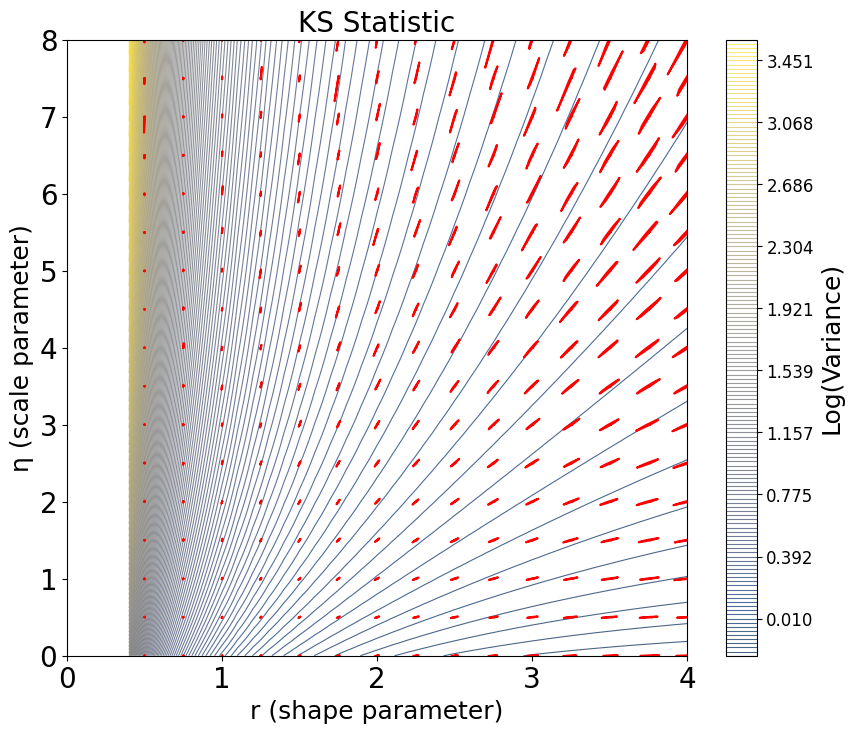

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate, interpolate, stats, special
from tqdm import tqdm
import pickle
import os
from sigfig import round

import git
from pathlib import Path
import os
import cv2
import numpy as np
from glob import glob

# Import MATLAB Engine API for Python
ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.getcwd()
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import *
os.chdir(CWD)


# Utility Functions (Updated)

def compute_cdf_vals(r, beta, xs, use_matlab=False, debug=False):
    prior_cdf = np.zeros_like(xs)
    if use_matlab:
        if debug:
            for j in tqdm(range(len(xs)), desc="Computing CDF with MATLAB"):
                prior_cdf[j] = eng.compute_cdf_using_gengamma(float(r), float(beta), float(xs[j]), nargout=1)
        else:
            for j, x in enumerate(xs):
                prior_cdf[j] = eng.compute_cdf_using_gengamma(float(r), float(beta), float(x), nargout=1)
    else:
        def gen_gamma_density(theta):
            return (np.abs(r) / special.gamma(beta)) * (theta) ** (r * beta - 1) * np.exp(-(theta) ** r)

        for idx, x in enumerate(xs):
            def integrand(theta):
                cdf_normal = stats.norm.cdf(x / np.sqrt(theta))
                return cdf_normal * gen_gamma_density(theta)
            # Integrate over theta from 0 to infinity
            result, _ = integrate.quad(integrand, 0, np.inf, limit=100)
            prior_cdf[idx] = result
            if debug and idx % 100 == 0:
                print(f"x={x:.2f}, CDF={prior_cdf[idx]:.5f}")
    return prior_cdf

def sample_prior(r, eta, size=1):
    beta = (eta + 1.5)/r 
    assert beta > 0
    vars = stats.gengamma.rvs(a=beta, c=r, size=size)
    x = np.random.normal(scale=np.sqrt(vars), size=size)
    return x

def compute_prior_cdf_using_gamma_cdf(r, eta, n_samples=1000, tail_bound=0.001, tail_percent=0.1, scale=1, use_matlab=True, eng=None, enforce_assert=True, return_assert=False, return_xs=False, debug=False):
    beta = (eta + 1.5) / r
    var_prior = scale * special.gamma(beta + 1/r) / special.gamma(beta)
    
    cheby = np.sqrt(var_prior / tail_bound)
    if np.isnan(var_prior) or np.isinf(var_prior):
        cheby = 1e100
    x_max = min(99, cheby)
    n_tail = int(n_samples * tail_percent) if cheby >= 120 else 0

    if debug:
        print(f"Params: r={r}, eta={eta}")
        print(f"Chebyshev bound: {cheby}")
        print(f"{'No tail' if n_tail == 0 else f'Tail samples: {n_tail}'}")

    xs_minus = np.concatenate((-np.logspace(np.log10(cheby), 2, n_tail),
                               np.linspace(-x_max, 0, n_samples//2-n_tail)))

    prior_cdf_minus = compute_cdf_vals(r, beta, xs_minus, use_matlab=use_matlab, debug=debug)

    xs_plus = -np.flip(xs_minus[:-1])
    prior_cdf_plus = 1 - np.flip(prior_cdf_minus[:-1])

    xs = np.concatenate((xs_minus, xs_plus))
    prior_cdf = np.concatenate((prior_cdf_minus, prior_cdf_plus))

    if debug:
        print(f"First CDF value: {prior_cdf[0]}")
        print(f"Last CDF value: {prior_cdf[-1]}")
        print(f"Tail bound: {tail_bound}")

    if return_assert or enforce_assert:
        eps = tail_bound
        if not (-eps < prior_cdf[0] < eps and 1 - eps < prior_cdf[-1] < 1 + eps):
            if return_assert:
                return (xs, None) if return_xs else None
            elif enforce_assert:
                raise AssertionError("CDF bounds not satisfied")
        
    xs = np.concatenate(([1.01 * xs[0]], xs, [1.01 * xs[-1]]))
    prior_cdf = np.concatenate(([0], prior_cdf, [1]))
    cdf_spline = interpolate.InterpolatedUnivariateSpline(x=xs, y=prior_cdf, k=3, ext='const')

    if return_assert or enforce_assert:
        x = np.sort(sample_prior(r, eta, 10000))
        res = stats.kstest(x, cdf_spline)
        if debug:
            print(res)
        if not 0 <= res.statistic <= 0.2:
            if return_assert:
                return (xs, None) if return_xs else None
            elif enforce_assert:
                raise AssertionError("KS test failed")

    return (xs, cdf_spline) if return_xs else cdf_spline

def compute_prior_cdf(r, eta, method='gamma_cdf', n_samples=1000, tail_bound=0.001, tail_percent=0.1, scale=1, use_matlab=True, eng=None, debug=False, enforce_assert=True, return_assert=False, return_xs=False):
    if method == 'gamma_cdf':
        return compute_prior_cdf_using_gamma_cdf(r=r, eta=eta, n_samples=n_samples, tail_bound=tail_bound, tail_percent=tail_percent, scale=scale, use_matlab=use_matlab, eng=eng, enforce_assert=enforce_assert, return_assert=return_assert, return_xs=return_xs, debug=debug)
    else:
        raise ValueError("Invalid method specified.")

def variance_prior(r, eta, scale=1):
    beta = (eta + 1.5)/r 
    var_prior = scale * special.gamma(beta + 1 / r) / special.gamma(beta)
    return var_prior

# Main Script

# Lists of r and η values for level sets
r_ellipses = [0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4]
eta_ellipses = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8]

# Define ε
epsilon = 0.00001

# Define θ values from 0 to 2π
theta_values = np.linspace(0, 2 * np.pi, num=100)  # Granularity specified here

# Define x values for CDF evaluation
xs = np.linspace(-10, 10, 1000)

# KS statistic level for level set
KS_level = 0.0001  # You can change this value to adjust the level set

# Directory to save gradient data
gradient_data_dir = 'ks_gradient_data'
os.makedirs(gradient_data_dir, exist_ok=True)

# Function to format numbers for filenames
def format_number(x, multiplier):
    return int(np.round(x * multiplier))

# Initialize lists for plotting level sets
all_r_values = []
all_eta_values = []

# Grid values for contour plot
r_contour = [round(i*0.01 + 0.5, sigfigs=2) for i in range(-10, 360)]
eta_contour = [round(j*0.02 + 1, sigfigs=2) for j in range(-50, 400)]
R_contour, Eta_contour = np.meshgrid(r_contour, eta_contour)

# Compute variance_prior values for the contour plot
var_prior_values = variance_prior(R_contour, Eta_contour)

# Loop over all (r0, η0) pairs
for r0 in r_ellipses:
    for eta0 in eta_ellipses:
        print(f"Processing r0={r0}, eta0={eta0}")
        
        # Format numbers for filenames
        r0_int = format_number(r0, 100)
        eta0_int = format_number(eta0, 100)
        epsilon_int = format_number(epsilon, 1e6)
        theta_num = len(theta_values)
        
        # File name for gradient data
        gradient_file = os.path.join(
            gradient_data_dir,
            f'gradient_data_r{r0_int}_eta{eta0_int}_eps{epsilon_int}_theta{theta_num}.pkl'
        )
        
        # Try to load existing gradient data
        if os.path.exists(gradient_file):
            print(f"Loading existing gradient data from {gradient_file}")
            with open(gradient_file, 'rb') as f:
                gradient_data = pickle.load(f)
            theta_values = gradient_data['theta_values']
            KS_derivatives = gradient_data['KS_derivatives']
        else:
            print(f"Computing gradient data for r0={r0}, eta0={eta0}")
            # Compute reference CDF at (r0, η0)
            try:
                cdf_p0 = compute_prior_cdf(r=r0, eta=eta0, n_samples=1000, use_matlab=True, eng=eng, debug=False)
                cdf_p0_values = cdf_p0(xs)
            except Exception as e:
                print(f"Error computing reference CDF for r={r0}, eta={eta0}: {e}")
                continue  # Skip this pair if there's an error

            # Initialize array to store derivatives
            KS_derivatives = np.zeros_like(theta_values)
            
            # Loop over θ values and compute derivatives
            for idx, theta in tqdm(enumerate(theta_values), total=len(theta_values), desc='Computing derivatives'):
                delta_r = epsilon * np.cos(theta)
                delta_eta = epsilon * np.sin(theta)
                r_prime = r0 + delta_r
                eta_prime = eta0 + delta_eta
                # Compute CDF for (r', η')
                try:
                    cdf_p_prime = compute_prior_cdf(r=r_prime, eta=eta_prime, n_samples=1000, use_matlab=True, eng=eng, debug=False)
                    cdf_p_prime_values = cdf_p_prime(xs)
                    # Compute KS statistic
                    ks_stat = np.max(np.abs(cdf_p_prime_values - cdf_p0_values))
                    # Approximate derivative as ks_stat / epsilon
                    ks_derivative = ks_stat / epsilon
                    # Store derivative
                    KS_derivatives[idx] = ks_derivative
                except Exception as e:
                    print(f"Error computing CDF for r={r_prime}, eta={eta_prime}: {e}")
                    KS_derivatives[idx] = np.nan
            
            # Save gradient data
            gradient_data = {
                'theta_values': theta_values,
                'KS_derivatives': KS_derivatives,
                'epsilon': epsilon,
                'theta_num': theta_num,
                'r0': r0,
                'eta0': eta0
            }
            with open(gradient_file, 'wb') as f:
                pickle.dump(gradient_data, f)
        
        # Now, use the gradient data to draw a level set
        # For each θ, compute the distance s where KS_statistic equals KS_level
        # Approximate s = KS_level / KS_derivative
        s_values = KS_level / KS_derivatives  # s = KS_level / derivative
        print(f"KS Derivatives range: {np.nanmin(KS_derivatives)}, {np.nanmax(KS_derivatives)}")
        # Handle division by zero or NaN
        s_values = np.nan_to_num(s_values, nan=np.inf, posinf=np.inf, neginf=-np.inf)
        
        # Remove infinite or NaN s_values
        valid_indices = np.isfinite(s_values)
        s_values = s_values[valid_indices]
        theta_values_valid = theta_values[valid_indices]
        
        # Compute the points on the level set
        r_values = r0 + s_values * np.cos(theta_values_valid)
        eta_values = eta0 + s_values * np.sin(theta_values_valid)
        
        # Store the level set points for plotting
        all_r_values.append(r_values)
        all_eta_values.append(eta_values)

# Plotting
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_xlabel('r (shape parameter)', fontsize=18)
ax.set_ylabel('η (scale parameter)', fontsize=18)
# ax.set_title(f'Level Sets of KS Statistic at Level {KS_level}\nε={epsilon}, θ samples={len(theta_values)}')
ax.set_title('KS Statistic', fontsize=20)

ax.set_xlim(0, 4)  # Set x-axis to start from 0, while keeping the upper limit automatic
ax.set_ylim(0, 8)  # Set y-axis to start from 0, while keeping the upper limit automatic


# Plot the variance prior contour
log_levels = np.logspace(np.log10(np.min(var_prior_values)), np.log10(np.max(var_prior_values)), 150)
contour = ax.contour(R_contour, Eta_contour, np.log10(var_prior_values), levels=np.log10(log_levels), cmap='cividis', alpha=0.7, linewidths=0.8)
cbar = fig.colorbar(contour, ax=ax)
cbar.set_label('Log(Variance)', fontsize=18)
cbar.ax.tick_params(labelsize=12)

# Plot level sets
for r_values, eta_values, r0, eta0 in zip(all_r_values, all_eta_values, r_ellipses * len(eta_ellipses), np.repeat(eta_ellipses, len(r_ellipses))):
    ax.plot(r_values, eta_values, color='red', label=f'r0={r0}, η0={eta0}')


ax.tick_params(axis='both', which='major', labelsize=20)


fig.savefig('plots/ks_statistic_plot.png', bbox_inches='tight')
plt.show()


# KL Plot

/var/folders/0c/5hhs4r6n7pnc4jcl295d7j_c0000gn/T/ipykernel_29931/634042565.py:15: UserWarning: 2 significant figures requested from number with only 1 significant figures
  r_contour = [round(i*0.01 + 0.5, sigfigs=2) for i in range(-10, 360)]
/var/folders/0c/5hhs4r6n7pnc4jcl295d7j_c0000gn/T/ipykernel_29931/634042565.py:16: UserWarning: 2 significant figures requested from number with only 1 significant figures
  eta_contour = [round(j*0.02 + 1, sigfigs=2) for j in range(-50, 400)]
/var/folders/0c/5hhs4r6n7pnc4jcl295d7j_c0000gn/T/ipykernel_29931/634042565.py:85: RuntimeWarning: divide by zero encountered in scalar divide
  width, height = scale_factor / np.sqrt(s[0]), scale_factor / np.sqrt(s[1])  # Axis lengths
/Users/brandonmarks/opt/anaconda3/envs/HBMV/lib/python3.10/site-packages/matplotlib/transforms.py:2070: RuntimeWarning: invalid value encountered in scalar multiply
  self._mtx[1, 0] *= sy
/Users/brandonmarks/opt/anaconda3/envs/HBMV/lib/python3.10/site-packages/matplotlib/transf

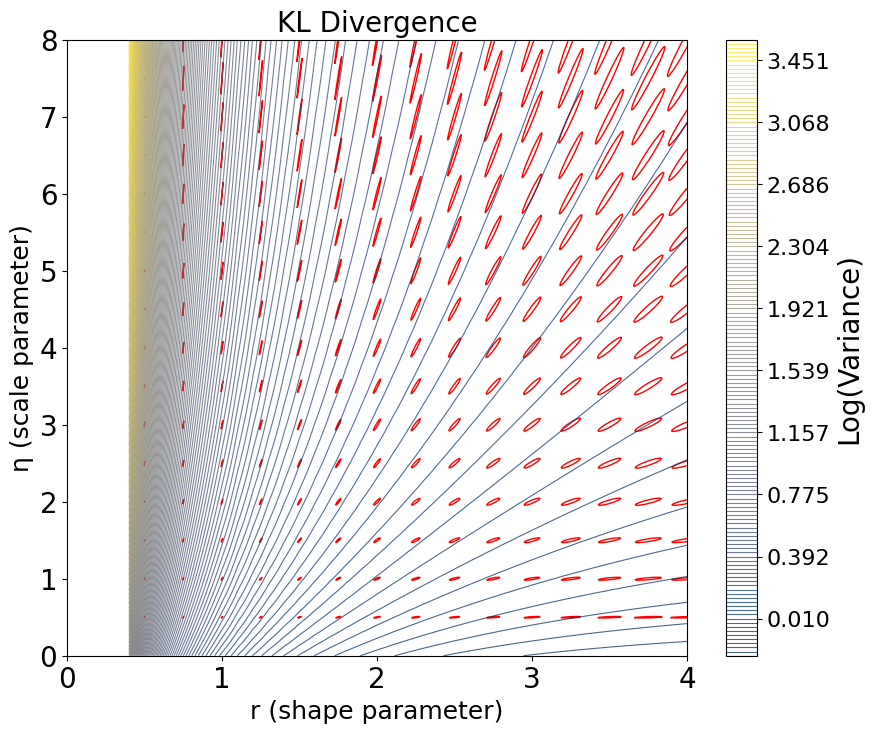

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy.special
import os
import pickle
from sigfig import round

# Grid values for ellipses
r_ellipses = [0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4]
eta_ellipses = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8]
R_ellipses, Eta_ellipses = np.meshgrid(r_ellipses, eta_ellipses)

# Finer grid values for the contour plot
r_contour = [round(i*0.01 + 0.5, sigfigs=2) for i in range(-10, 360)]
eta_contour = [round(j*0.02 + 1, sigfigs=2) for j in range(-50, 400)]
R_contour, Eta_contour = np.meshgrid(r_contour, eta_contour)

# Directory for storing Hessian matrices
hessian_dir = 'kl_hessian_matrices'
os.makedirs(hessian_dir, exist_ok=True)

# Function to generate a file path for a given (r, eta) pair
def get_hessian_path(r_val, eta_val):
    return os.path.join(hessian_dir, f'hessian_R{r_val}_Eta{eta_val}.pkl')

# Function to calculate variance_prior
def variance_prior(r, eta, scale=1):
    beta = (eta + 1.5) / r
    var_prior = scale * scipy.special.gamma(beta + 1 / r) / scipy.special.gamma(beta)
    return var_prior

# Hessian function
def hessian(r, eta):
    return np.array([[r, 0], [0, eta]])

# Example function to check if a matrix is positive definite
def is_pos_def(matrix):
    return np.all(np.linalg.eigvals(matrix) > 0)

# Initialize grid for var_prior values for the contour plot
var_prior_values = variance_prior(R_contour, Eta_contour)

# Plotting
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_xlabel('r (shape parameter)', fontsize=18)
ax.set_ylabel('η (scale parameter)', fontsize=18)
ax.set_title('KL Divergence', fontsize=20)

# Set x and y axis limits
ax.set_xlim(0, 4)
ax.set_ylim(0, 8)

# Overlay contour plot with reduced opacity and no labels
log_levels = np.logspace(np.log10(np.min(var_prior_values)), np.log10(np.max(var_prior_values)), 150)
contour = ax.contour(R_contour, Eta_contour, np.log10(var_prior_values), levels=np.log10(log_levels), cmap='cividis', alpha=0.7, linewidths=0.8)

# Add colorbar
cbar = fig.colorbar(contour, ax=ax)
cbar.set_label('Log(Variance)', fontsize=20)
cbar.ax.tick_params(labelsize=16)

# Plot ellipses
scale_factor = 0.01
rows, cols = R_ellipses.shape  # Get correct dimensions of the meshgrid

for i in range(rows):  # Loop over rows
    for j in range(cols):  # Loop over columns
        hessian_path = get_hessian_path(R_ellipses[i, j], Eta_ellipses[i, j])
        
        # Check if the Hessian matrix is already stored
        if os.path.exists(hessian_path):
            with open(hessian_path, 'rb') as f:
                H = pickle.load(f)
        else:
            #print(i, j)
            # Calculate the Hessian matrix if not already stored
            H = hessian(R_ellipses[i, j], Eta_ellipses[i, j])
            # Store the Hessian matrix in a pickle file
            with open(hessian_path, 'wb') as f:
                pickle.dump(H, f)
        
        U, s, Vt = np.linalg.svd(H)
        angle = np.arctan2(U[0, 1], U[0, 0]) * 180 / np.pi  # Convert radian to degree
        width, height = scale_factor / np.sqrt(s[0]), scale_factor / np.sqrt(s[1])  # Axis lengths
        ellipse = patches.Ellipse((R_ellipses[i, j], Eta_ellipses[i, j]), width, height, angle=angle, edgecolor='red', facecolor='none')
        ax.add_patch(ellipse)

# Customize tick parameters
ax.tick_params(axis='both', which='major', labelsize=20)

# Show the plot
plt.show()
fig.savefig('plots/kl_divergence_plot.png', bbox_inches='tight')

/var/folders/0c/5hhs4r6n7pnc4jcl295d7j_c0000gn/T/ipykernel_29931/3045576532.py:158: UserWarning: 2 significant figures requested from number with only 1 significant figures
  r_contour = [round(i*0.01 + 0.5, sigfigs=2) for i in range(-10, 360)]
/var/folders/0c/5hhs4r6n7pnc4jcl295d7j_c0000gn/T/ipykernel_29931/3045576532.py:159: UserWarning: 2 significant figures requested from number with only 1 significant figures
  eta_contour = [round(j*0.02 + 1, sigfigs=2) for j in range(-50, 400)]
/var/folders/0c/5hhs4r6n7pnc4jcl295d7j_c0000gn/T/ipykernel_29931/3045576532.py:288: UserWarning: 2 significant figures requested from number with only 1 significant figures
  r_contour = [round(i*0.01 + 0.5, sigfigs=2) for i in range(-10, 360)]
/var/folders/0c/5hhs4r6n7pnc4jcl295d7j_c0000gn/T/ipykernel_29931/3045576532.py:289: UserWarning: 2 significant figures requested from number with only 1 significant figures
  eta_contour = [round(j*0.02 + 1, sigfigs=2) for j in range(-50, 400)]


Processing r0=0.5, eta0=0
Loading existing gradient data from ks_gradient_data/gradient_data_r50_eta0_eps10_theta100.pkl
KS Derivatives range: 0.022075759099210442, 0.7914887269477865
Processing r0=0.5, eta0=0.5
Loading existing gradient data from ks_gradient_data/gradient_data_r50_eta50_eps10_theta100.pkl
KS Derivatives range: 0.013870231829749, 0.9391626459687162
Processing r0=0.5, eta0=1
Loading existing gradient data from ks_gradient_data/gradient_data_r50_eta100_eps10_theta100.pkl
KS Derivatives range: 0.010009018214240939, 1.0604514940504295
Processing r0=0.5, eta0=1.5
Loading existing gradient data from ks_gradient_data/gradient_data_r50_eta150_eps10_theta100.pkl
KS Derivatives range: 0.020745471407401794, 1.162211134958513
Processing r0=0.5, eta0=2
Loading existing gradient data from ks_gradient_data/gradient_data_r50_eta200_eps10_theta100.pkl
KS Derivatives range: 0.00741100764645175, 1.249205444120438
Processing r0=0.5, eta0=2.5
Loading existing gradient data from ks_gradient

/var/folders/0c/5hhs4r6n7pnc4jcl295d7j_c0000gn/T/ipykernel_29931/3045576532.py:358: RuntimeWarning: divide by zero encountered in scalar divide
  width, height = scale_factor / np.sqrt(s[0]), scale_factor / np.sqrt(s[1])  # Axis lengths


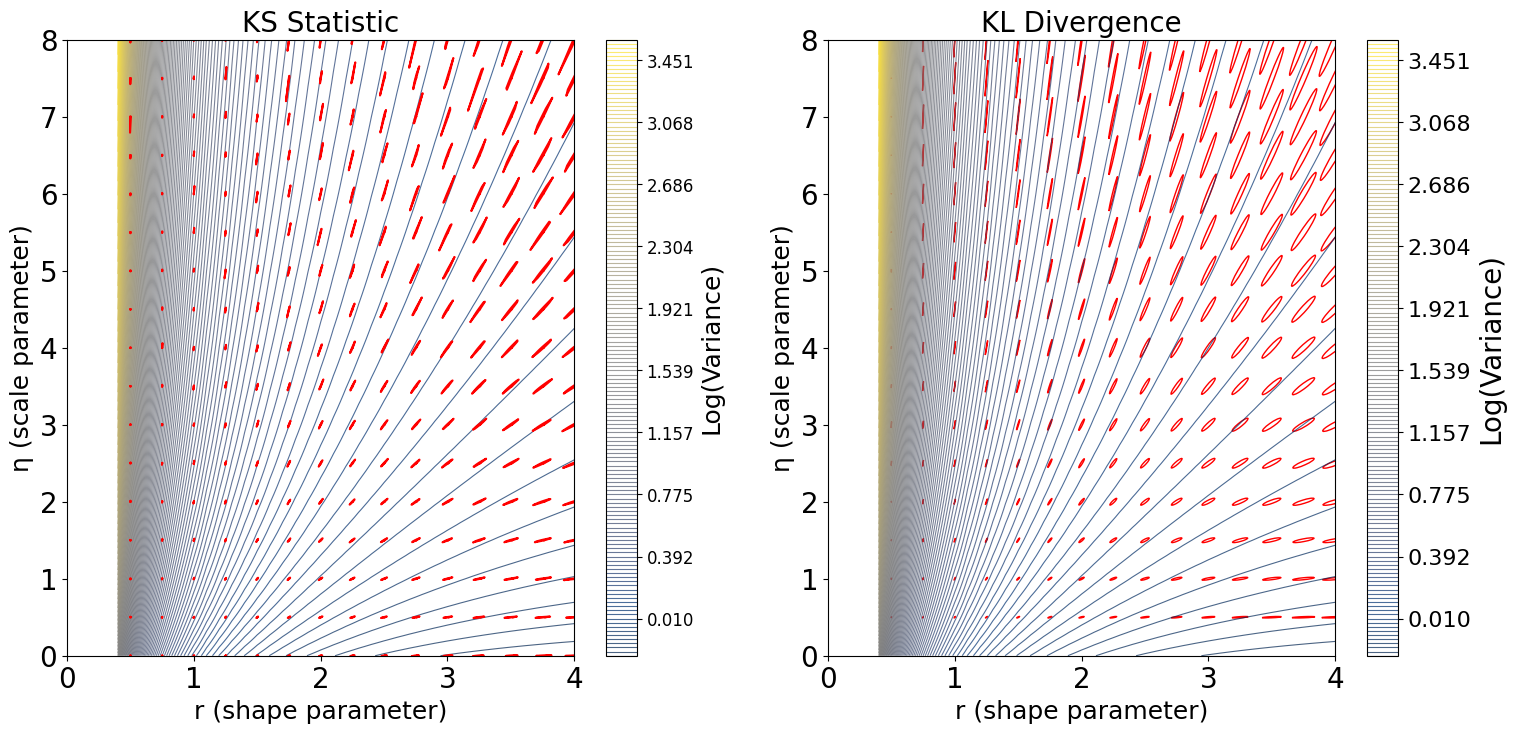